# Bernstein-Vazirani Algorithm

The Bernstein-Vazirani Algorithm is a black box quantum algorithm that can be used to find a secret key number.

This task can be carried out classically by querying the key $n$ times, being $n$ the number of digits in the key. Specifically, by acting with an AND gate it is possible to determine one by one each one of the (binary) digits. Using Bernstein-Vazirani algorithm, the secret number can be obtained by querying exactly *once*.

This algorithm bears great resemblance with the Deustsch-Jozsa algorithm. It requires a main register made up of $n$ qubits and an extra ancillary qubit, and these are also initialized in superposition states by acting with a set of Hadamard gates on them. The secret key is encoded in an oracle, which acts as a control on the ancilla. Analogously to the Deustsch-Jozsa algorithm, phase kickback is used to imprint a phase on the qubits in the main register. By acting with a second set of Hadamard gates, the resulting state of the main register qubits is nothing but the secret key number we are aiming to find. Finally, the number is retrieved by performing a measurement on the main register.

Mathematically, the oracle can be understood as a function $f(x) = s \cdot x$, where $s$ is the secret key. The algorithm steps can then be described as

$\begin{align} &|\psi_{0} \rangle = (H^{n}|00..0\rangle)(HX|0 \rangle) = \frac{1}{2^{n/2}}\sum_{x=0}^{2^{n}-1} |x \rangle|- \rangle \xrightarrow{U_{\textit{oracle}}} |\psi_{1} \rangle = \frac{1}{2^{(n+1)/2}}\sum_{x=0}^{2^{n}-1} |x \rangle(|0 \oplus f(x)\rangle- |1 \oplus f(x) \rangle) = \frac{1}{2^{n/2}}\sum_{x=0}^{2^{n}-1} (-1)^{f(x)} |x \rangle|-\rangle  \\
& = \frac{1}{2^{n/2}}\sum_{x=0}^{2^{n}-1} (-1)^{s \cdot x} |x \rangle|-\rangle \xrightarrow{H^{n}} |\psi_{2} \rangle =  |s \rangle |-\rangle  \end{align}$.

From these expressions it is easy to see how measuring the qubits in the main register yields the secret key - querying the function only *once*!

Refs.:

[1] Further details can be found in Qiskit tutorial notes: https://qiskit.org/textbook/ch-algorithms/bernstein-vazirani.html

[2] Nielsen and Chuang - *Quantum computation and quantum information*

In [7]:
from qiskit import *
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor

import numpy as np
%matplotlib inline 

In [47]:
# Load personal account
IBMQ.load_account() 

/opt/anaconda3/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

### Initialization

In [8]:
def initializer(circuit,nqubits):
    
    # Apply a Hadamard gate on each qubit in the circuit
    for qubit in range(nqubits):
        circuit.h(qubit)
    
    return circuit

### Oracle

The oracle receives the secret key as a binary number in string form. It then encodes the secret key by applying X gates to the qubits on the position of the '1' bits. Next, it applys a set of CNOT gates with the ancilla as the target and each qubit in the main register as a control. This allows for phase kickback to generate relative phases in the superposition state (generated by the initial set of Hadamard gates) of each qubit. Lastly, we reverse the encoding process by acting with X gates as in the first step.

In [39]:
def oracle(secret_key):
     
    nqubits = len(secret_key)
    oracle = QuantumCircuit(nqubits+1)
    
    # Encode secret key in the main register
    for qubit in range(nqubits):
        if secret_key[qubit] == '1':
            oracle.x(qubit)
            
    # Apply CNOT gates on the ancilla
    for qubit in range(nqubits):
        if secret_key[qubit] == '1':
            oracle.cx(qubit,nqubits)
    
    # Reverse encoding process
    for qubit in range(nqubits):
        if secret_key[qubit] == '1':
            oracle.x(qubit)
    
    oc = oracle.to_gate()
    oc.name = 'U$_{or}$'
    
    return oc

## Main circuit

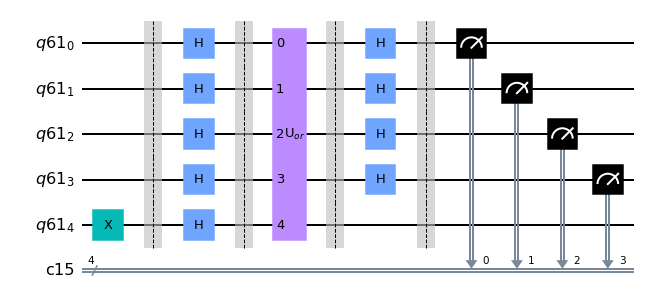

In [53]:
secret_key = 13 # Define secret key as integer number
secret_key = format(secret_key, 'b') # Turn it into a binary number
secret_key = secret_key[::-1] # Reverse the order of the key in otder to match Qiskit reading output

num_qubits = len(secret_key) # Number of qubits in the main register defined by the size of the key

qr = QuantumRegister(num_qubits+1)
cr = ClassicalRegister(num_qubits)

bv_circ = QuantumCircuit(qr,cr)

# Initialize the ancilla in the excited state
bv_circ.x(num_qubits)
bv_circ.barrier()

# Apply Hadamard gates on the entire circuit
bv_circ = initializer(bv_circ,num_qubits+1)
bv_circ.barrier()

# Add the oracle to the circuit
bv_circ.append(oracle(secret_key),qr)
bv_circ.barrier()

# Apply Hadamard gates onthe main register
bv_circ = initializer(bv_circ,num_qubits)
bv_circ.barrier()

# Measure qubits in the main register
for qubit in range(num_qubits):
    bv_circ.measure(qubit,qubit)

bv_circ.draw(output='mpl')


### Classical simulation

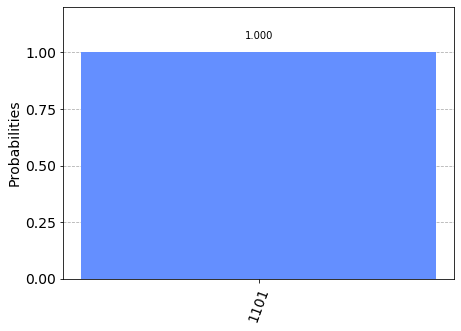

In [54]:
sim = Aer.get_backend('qasm_simulator')
bv_result = execute(bv_circ, backend = sim, shots = 1024).result()

plot_histogram(bv_result.get_counts())

As expected, we obtained 1101, 13 in binary, which is nothing but the secret key we defined in the main circuit.

### Quantum simulation 

In [55]:
provider = IBMQ.get_provider(hub = 'ibm-q')
simQ = provider.get_backend('ibmq_valencia')

In [56]:
bv_job = execute(bv_circ, backend = simQ, shots = 1024)

print(bv_job.job_id())
job_monitor(bv_job)

5ffaf5c16d0950770a6cb1eb
Job Status: job has successfully run


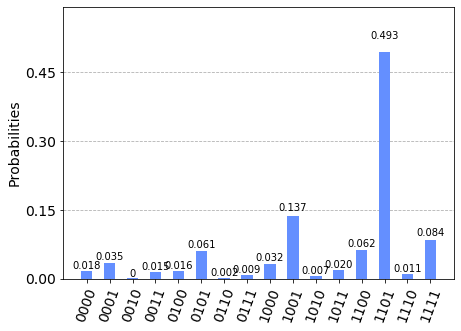

In [57]:
bv_resultQ = bv_job.result()
plot_histogram(bv_resultQ.get_counts())

Using a real device we can still find the secret key, but now finite probabilities occur for other states due to the intrinsic noise of the device.